In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point, Polygon

import folium
from folium import Map
from folium.map import Layer, FeatureGroup,LayerControl,Marker
from folium.plugins import MarkerCluster,FeatureGroupSubGroup,Fullscreen

# Data Preparation

In [87]:
df = pd.read_csv(r'.\data\West_Nile_Virus_by_County.csv').reset_index()

df.drop(['id'], axis=1, inplace=True)

print(df.shape)
df.head()

(1395, 5)


,index,Year,Week_Reported,County,Positive_Cases
0,0,2006,35,Alameda,1
1,1,2006,33,Butte,4
2,2,2006,34,Butte,1
3,3,2006,35,Butte,10
4,4,2006,36,Butte,2


In [88]:
df.nunique()

index             1395
Year                10
Week_Reported       31
County              46
Positive_Cases      30
dtype: int64

In [89]:
# df_coord = pd.read_csv(r'C:\Users\rmartinez4\Downloads\us-county-boundaries.csv', sep=';')
# df_coord.head()

In [90]:
# df_coord = df_coord[df_coord['STATE_NAME']=='California']

In [91]:
# df_coord.nunique()

In [92]:
# df_coord = df_coord[['Geo Point', 'NAMELSAD']]
# df_coord = df_coord.to_csv(r'.\data\us-county-boundaries.csv', index=False)
df_coord = pd.read_csv(r'.\data\us-county-boundaries.csv').reset_index()
print(df_coord.shape)
df_coord.head()

(58, 3)


,index,Geo Point,NAMELSAD
0,0,"36.0753604529,-119.815502709",Kings County
1,1,"36.6057058971,-121.074995529",San Benito County
2,2,"36.7581801263,-119.649322632",Fresno County
3,3,"40.0046824769,-120.838597596",Plumas County
4,4,"36.5111268089,-117.410789686",Inyo County


In [93]:
import py_stringmatching as sm
import py_stringsimjoin as ssj

ws = sm.WhitespaceTokenizer(return_set=True)

output_pairs = ssj.jaccard_join(df, df_coord, 'index', 'index', 'County', 'NAMELSAD', ws, 0.4, 
                                l_out_attrs=['County'], r_out_attrs=['NAMELSAD'])


c:\users\rmartinez4\anaconda3\envs\geo_env\lib\site-packages\py_stringsimjoin\utils\validation.py:30: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if attr_type != pd.np.object:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [94]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
output_pairs.head()

,_id,l_index,r_index,l_County,r_NAMELSAD,_sim_score
0,0,50,0,Kings,Kings County,0.5
1,1,200,0,Kings,Kings County,0.5
2,2,201,0,Kings,Kings County,0.5
3,3,202,0,Kings,Kings County,0.5
4,4,203,0,Kings,Kings County,0.5


<AxesSubplot:ylabel='Frequency'>

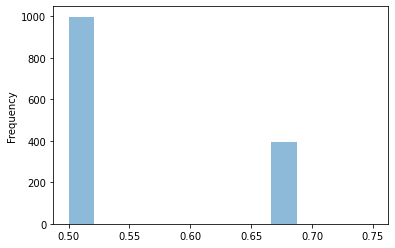

In [95]:
output_pairs['_sim_score'].plot.hist(bins=12, alpha=0.5)

In [96]:
df_match = output_pairs[['l_County', 'r_NAMELSAD', '_sim_score']]
df_match.drop_duplicates(inplace=True)

print(df_match.shape)
df_match.head()

(46, 3)


<ipython-input-96-92e6772cc916>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_match.drop_duplicates(inplace=True)


,l_County,r_NAMELSAD,_sim_score
0,Kings,Kings County,0.500000
19,Fresno,Fresno County,0.500000
103,Contra Costa,Contra Costa County,0.666667
137,Sutter,Sutter County,0.500000
164,Stanislaus,Stanislaus County,0.500000


In [97]:
df_final = df.merge(
                    df_match, left_on='County', right_on='l_County'
                    ).merge(
                            df_coord, left_on='r_NAMELSAD', right_on='NAMELSAD', how='left'
                            )

In [98]:
print(df_final.shape)
df_final.head()

(1395, 11)


,index_x,Year,Week_Reported,County,Positive_Cases,l_County,r_NAMELSAD,_sim_score,index_y,Geo Point,NAMELSAD
0,0,2006,35,Alameda,1,Alameda,Alameda County,0.5,50,"37.6504930265,-121.917998966",Alameda County
1,300,2008,32,Alameda,1,Alameda,Alameda County,0.5,50,"37.6504930265,-121.917998966",Alameda County
2,512,2010,43,Alameda,1,Alameda,Alameda County,0.5,50,"37.6504930265,-121.917998966",Alameda County
3,673,2012,42,Alameda,1,Alameda,Alameda County,0.5,50,"37.6504930265,-121.917998966",Alameda County
4,674,2012,43,Alameda,1,Alameda,Alameda County,0.5,50,"37.6504930265,-121.917998966",Alameda County


In [99]:
cols = ['Year', 'Week_Reported', 'County', 'Positive_Cases', 'Geo Point']
df_final[cols].to_csv(r'.\data\final_df.csv', index=False)

# Data Visualization

In [100]:
df_final = pd.read_csv(r'.\data\final_df.csv')

print(df_final.shape)
df_final.head()

(1395, 5)


,Year,Week_Reported,County,Positive_Cases,Geo Point
0,2006,35,Alameda,1,"37.6504930265,-121.917998966"
1,2008,32,Alameda,1,"37.6504930265,-121.917998966"
2,2010,43,Alameda,1,"37.6504930265,-121.917998966"
3,2012,42,Alameda,1,"37.6504930265,-121.917998966"
4,2012,43,Alameda,1,"37.6504930265,-121.917998966"


In [101]:
df_final.groupby(['Year', 'County']).size()

Year  County         
2006  Alameda             1
      Butte               8
      Colusa              3
      Contra Costa        6
      El Dorado           2
      Fresno              8
      Glenn               6
      Imperial            1
      Kern               15
      Kings               1
      Lake                2
      Los Angeles         8
      Marin               1
      Merced              4
      Modoc               2
      Mono                1
      Napa                1
      Nevada              1
      Orange              4
      Placer              6
      Riverside           3
      Sacramento         10
      San Bernardino      2
      San Diego           1
      San Joaquin         5
      San Luis Obispo     1
      Santa Clara         4
      Shasta              4
      Solano              2
      Stanislaus          8
      Sutter              6
      Tehama              2
      Tulare              5
      Ventura             2
      Yolo                

In [102]:
df_final['Week_Reported'] = df_final['Week_Reported'].astype(str)
df_final['Week_Reported'] = [str(i) + ' (' + str(j) + ')' for i,j in zip(df_final['Week_Reported'], df_final['Positive_Cases'])]
df_text = df_final.groupby(['Year','County'])['Week_Reported'].apply(', '.join).reset_index()

df_text.head()

,Year,County,Week_Reported
0,2006,Alameda,35 (1)
1,2006,Butte,"33 (4), 34 (1), 35 (10), 36 (2), 37 (8), 38 (3), 39 (2), 43 (1)"
2,2006,Colusa,"31 (1), 35 (1), 41 (1)"
3,2006,Contra Costa,"34 (3), 35 (1), 36 (1), 37 (1), 38 (1), 39 (1)"
4,2006,El Dorado,"34 (1), 48 (1)"


In [103]:
df_final = df_final.groupby(['Year', 'County', 'Geo Point'], as_index=False)['Positive_Cases'].sum()

In [104]:
df_final = df_final.merge(df_text, on=['Year', 'County'])

In [105]:
set(df_final.Year)

{2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015}

In [106]:
df_final.nunique()

Year               10
County             46
Geo Point          46
Positive_Cases     49
Week_Reported     226
dtype: int64

In [107]:
df_all_years = df_final.groupby(['County', 'Geo Point'], as_index=False)['Positive_Cases'].sum()
df_all_years['Year'] = 'All'
df_all_years['Week_Reported'] = 'Not Applicable'

df_all_years.head()

,County,Geo Point,Positive_Cases,Year,Week_Reported
0,Alameda,"37.6504930265,-121.917998966",6,All,Not Applicable
1,Amador,"38.446389504,-120.651115621",1,All,Not Applicable
2,Butte,"39.6669293633,-121.600671735",170,All,Not Applicable
3,Calaveras,"38.204606803,-120.554132098",1,All,Not Applicable
4,Colusa,"39.177573113,-122.237029616",15,All,Not Applicable


In [109]:
df_final = pd.concat([df_all_years, df_final])

In [110]:
print(df_final.shape)
df_final.head()

(324, 5)


,County,Geo Point,Positive_Cases,Year,Week_Reported
0,Alameda,"37.6504930265,-121.917998966",6,All,Not Applicable
1,Amador,"38.446389504,-120.651115621",1,All,Not Applicable
2,Butte,"39.6669293633,-121.600671735",170,All,Not Applicable
3,Calaveras,"38.204606803,-120.554132098",1,All,Not Applicable
4,Colusa,"39.177573113,-122.237029616",15,All,Not Applicable


In [111]:
print(df_final[df_final.County=='San Francisco'])

            County               Geo Point  Positive_Cases  Year  \
29   San Francisco  37.765294, -122.431600               3   All   
126  San Francisco  37.765294, -122.431600               1  2010   
174  San Francisco  37.765294, -122.431600               1  2012   
202  San Francisco  37.765294, -122.431600               1  2013   

      Week_Reported  
29   Not Applicable  
126          53 (1)  
174          39 (1)  
202          35 (1)  


In [114]:
# print(set(df_final['Week_Reported']))

In [115]:
geom = [Point(float(i.split(',')[1]), float(i.split(',')[0]))
        for i in df_final['Geo Point']]

In [116]:
A_gdf = gpd.GeoDataFrame(df_final,geometry = geom)
A_gdf.head()

,County,Geo Point,Positive_Cases,Year,Week_Reported,geometry
0,Alameda,"37.6504930265,-121.917998966",6,All,Not Applicable,POINT (-121.91800 37.65049)
1,Amador,"38.446389504,-120.651115621",1,All,Not Applicable,POINT (-120.65112 38.44639)
2,Butte,"39.6669293633,-121.600671735",170,All,Not Applicable,POINT (-121.60067 39.66693)
3,Calaveras,"38.204606803,-120.554132098",1,All,Not Applicable,POINT (-120.55413 38.20461)
4,Colusa,"39.177573113,-122.237029616",15,All,Not Applicable,POINT (-122.23703 39.17757)


<AxesSubplot:>

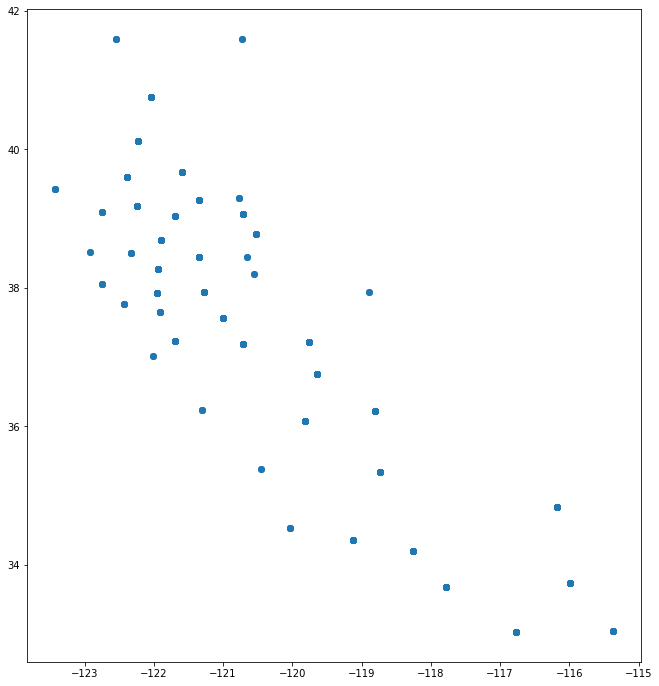

In [117]:
A_gdf.plot(figsize = (12,12))

In [118]:
set(A_gdf['County'])

{'Alameda',
 'Amador',
 'Butte',
 'Calaveras',
 'Colusa',
 'Contra Costa',
 'El Dorado',
 'Fresno',
 'Glenn',
 'Imperial',
 'Kern',
 'Kings',
 'Lake',
 'Los Angeles',
 'Madera',
 'Marin',
 'Mendocino',
 'Merced',
 'Modoc',
 'Mono',
 'Monterey',
 'Napa',
 'Nevada',
 'Orange',
 'Placer',
 'Riverside',
 'Sacramento',
 'San Bernardino',
 'San Diego',
 'San Francisco',
 'San Joaquin',
 'San Luis Obispo',
 'Santa Barbara',
 'Santa Clara',
 'Santa Cruz',
 'Shasta',
 'Siskiyou',
 'Solano',
 'Sonoma',
 'Stanislaus',
 'Sutter',
 'Tehama',
 'Tulare',
 'Ventura',
 'Yolo',
 'Yuba'}

In [119]:
year_dict = {}

for y in set(A_gdf['Year']):
    year_dict[y] = A_gdf[A_gdf.Year==y].reset_index(drop=True)

In [120]:
# year_dict.keys()

In [121]:
# year_dict.values()

In [122]:
def make_cmap(n, name='coolwarm'):
    ## name must be a valid cmap name
    ## returns cmap segmented into n-discrete parts
    return plt.cm.get_cmap(name, n)

cmap = make_cmap(len(year_dict),name = 'YlOrRd')

color_dict = {}

for i,code in enumerate(year_dict):
    color = cmap(i)
    
    if code != 'All':   
        color_dict[code] = f"RGB({color[0]*256},{color[1]*256},{color[2]*256})"
    else:
        color_dict[code] = f"RGB({0},{70},{139})"

In [123]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 0 to 277
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   County          324 non-null    object  
 1   Geo Point       324 non-null    object  
 2   Positive_Cases  324 non-null    int64   
 3   Year            324 non-null    object  
 4   Week_Reported   324 non-null    object  
 5   geometry        324 non-null    geometry
dtypes: geometry(1), int64(1), object(4)
memory usage: 17.7+ KB


In [124]:
# gdf.head()

In [125]:
# function to transform coordinates into a circle of 10 points, one per year

# Generate dictionary with offsets
r = 0.001 # In degrees
years = list(range(2006,2016))
angles = np.arange(0,2*np.pi,2*np.pi/11)
lon_offset = np.cos(angles)
lat_offset = np.sin(angles)
offsets = {}

offsets['All'] = [0,0]
for year,lon,lat in zip(years,lon_offset,lat_offset):
    offsets[year] = [lon,lat]

In [126]:
offsets

{'All': [0, 0],
 2006: [1.0, 0.0],
 2007: [0.8412535328311812, 0.5406408174555976],
 2008: [0.41541501300188644, 0.9096319953545183],
 2009: [-0.142314838273285, 0.9898214418809328],
 2010: [-0.654860733945285, 0.7557495743542583],
 2011: [-0.9594929736144974, 0.28173255684142967],
 2012: [-0.9594929736144975, -0.2817325568414294],
 2013: [-0.6548607339452852, -0.7557495743542582],
 2014: [-0.14231483827328523, -0.9898214418809327],
 2015: [0.41541501300188605, -0.9096319953545186]}

In [127]:
def convert_coord(year,x,y,offsets,r):
    x2 = x + offsets[year][0]*r
    y2 = y + offsets[year][1]*r
    return x2, y2

In [128]:
# let's make a web map

ca_map = folium.Map(location = [36.778259, -119.417931],
                          zoom_start = 6,
                          tiles = 'Stamen Terrain',
                          control_scale=True, 
                          prefer_canvas = True)
folium.TileLayer('Stamen Toner').add_to(ca_map)
folium.TileLayer('cartodbpositron').add_to(ca_map)

Fullscreen(
    title='Expand me',
    title_cancel='Exit fullscreen',
    force_separate_button=True
).add_to(ca_map)

for y in year_dict:
    
    gdf = year_dict[y].fillna("")
    
    def pointcolors(counter):
        return(color_dict[y])
    
    gdf['color'] = gdf.apply(pointcolors,axis = 1)
    
    marker_cluster = MarkerCluster(control = False)
    marker_cluster.add_to(ca_map)
    
    sub_group = FeatureGroupSubGroup(marker_cluster, name = y, control = True, show = True)
    
    for point in range(0, len(gdf)):
        
        html = """
                <h3>{COUNTY}</h3><br>
                <b>Year:</b> {YEAR}<br>
                <b>Number of Positive Cases:</b> {CASES}<br>
                <b>Weeks Reported:</b> {WEEKS}<br>
            """
        popup_contents = folium.Html(html.format(
                                                    COUNTY = gdf['County'][point],
                                                     YEAR = gdf['Year'][point],
                                                     CASES = gdf['Positive_Cases'][point],
                                                     WEEKS = gdf['Week_Reported'][point]),
                                         script = True)
        popup = folium.Popup(popup_contents, max_width=2650)
        
        new_x, new_y = convert_coord(y,gdf.geometry[point].x, gdf.geometry[point].y, offsets, r = 0.025)
        
#         print(gdf.geometry[point].x, gdf.geometry[point].y)
        COLOR = gdf['color'][point]
        FILL_COLOR = gdf['color'][point]
        OPACITY = 0.2 if y!= 'All' else 0.5
        
        folium.vector_layers.CircleMarker(radius = 20,
                                              location = (new_y,
                                                          new_x),
                                              popup = popup,
                                              color = COLOR,
                                              fill = True,
                                              fill_color = FILL_COLOR,
                                              name = y,
                                              control = True,
                                              overlay = True,
                                              fill_opacity = OPACITY
                                             ).add_to(sub_group)
        
    sub_group.add_to(ca_map)
folium.map.LayerControl(collapsed=False).add_to(ca_map)
ca_map.save('./West_Nile_Virus_folium_map.html')
ca_map